# Notebook 1 - Aprendizagem Supervisionada

Este notebook foca-se na classificação de jogadores do EA FC por grupo de posição (GK, DEF, MID, ATT) a partir de atributos físicos e técnicos. O objetivo é preparar os dados, treinar vários modelos e selecionar o que apresenta melhor desempenho.


## Dataset:
Transferir em: https://www.kaggle.com/datasets/the-guardian/olympic-games

Introduzir em `DATA/Olympics`

In [48]:
# Célula opcional para instalar dependências localmente.
print("Olá Mundo!")

%pip install --upgrade pip
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install mlxtend


Olá Mundo!
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Importar o conjunto de dados e preparar os dados

Nesta secção carregamos os ficheiros CSV, juntamos as duas tabelas (masculino e feminino) e criamos as primeiras colunas auxiliares.


### O que será carregado
- `df_jogadores_masculinos`: base de jogadores masculinos (CSV EA FC)
- `df_jogadoras_femininas`: base de jogadoras femininas (CSV EA FC)
- As colunas são mantidas como no conjunto de dados original; o género é adicionado manualmente na próxima etapa.


In [49]:
import pandas as pd

# Carrega os conjuntos de dados brutos com jogadores masculinos e femininos.
df_jogadores_masculinos = pd.read_csv("Data/EA_FC/male_players.csv", low_memory=False)
df_jogadoras_femininas = pd.read_csv("Data/EA_FC/female_players.csv")


In [50]:
# Adiciona a coluna de género e junta todos os jogadores num único DataFrame.
df_jogadores_masculinos["genero"] = "M"
df_jogadoras_femininas["genero"] = "F"

df_jogadores_todos = pd.concat(
    [df_jogadores_masculinos, df_jogadoras_femininas],
    ignore_index=True
)

# Filtra apenas os jogadores da edição FC 24.
df_jogadores_fc24 = df_jogadores_todos[df_jogadores_todos["fifa_version"] == 24].copy()


### Estrutura do conjunto de dados unificado
- `df_jogadores_todos`: concatenação de todos os jogadores com a coluna `genero` preenchida.
- `df_jogadores_fc24`: filtro para a versão `fifa_version == 24`, criando uma cópia para evitar avisos de `SettingWithCopy`.
- A filtragem garante que apenas a edição FC 24 entra no treino e na avaliação.


# Selecionar os dados relevantes

Nesta etapa agrupamos as posições do jogador em categorias simples e preparamos as colunas que irão alimentar os modelos.


In [51]:
def mapear_grupo_posicao(posicoes_str: str) -> str:
    """
    Mapeia a posição principal do jogador para um grupo simplificado
    (GK, DEF, MID, ATT ou OTHER).
    """
    if pd.isna(posicoes_str):
        return "OTHER"
    posicao_principal = posicoes_str.split(",")[0].strip()
    defensores = {"CB", "LB", "RB", "LWB", "RWB"}
    medios = {"CDM", "CM", "CAM", "LM", "RM"}
    avancados = {"ST", "CF", "LW", "RW"}

    if posicao_principal == "GK":
        return "GK"
    if posicao_principal in defensores:
        return "DEF"
    if posicao_principal in medios:
        return "MID"
    if posicao_principal in avancados:
        return "ATT"
    return "OTHER"

# Cria a coluna categórica com os grupos de posição.
df_jogadores_fc24["grupo_posicao"] = df_jogadores_fc24["player_positions"].apply(mapear_grupo_posicao)


In [52]:
# Seleciona atributos detalhados por prefixo (como no notebook2).
prefixos_detalhe = (
    "attacking_",
    "skill_",
    "movement_",
    "power_",
    "mentality_",
    "defending_",
)
atributos_detalhados = [
    c for c in df_jogadores_fc24.columns if c.startswith(prefixos_detalhe)
]
colunas_atributos = sorted(atributos_detalhados) + [
    "height_cm",
    "weight_kg",
    "age",
]
# Remove linhas com valores em falta e separa atributos (X) e alvo (y).
df_dados_treino = df_jogadores_fc24.dropna(subset=colunas_atributos + ["grupo_posicao"]).copy()
matriz_atributos = df_dados_treino[colunas_atributos]
rotulos_posicao = df_dados_treino["grupo_posicao"]


### Conjunto de atributos e alvo
- `colunas_atributos`: atributos detalhados por prefixo (attacking/skill/movement/power/mentality/defending) + altura, peso e idade.
- `df_dados_treino`: registos sem valores em falta nas colunas selecionadas e em `grupo_posicao`.
- `matriz_atributos` (`X`) e `rotulos_posicao` (`y`) são extraídos aqui e usados em todo o fluxo.


## Dividir os dados em treino e teste, e escalar os atributos

A divisão treino/teste evita avaliar o modelo nos dados vistos durante o treino. A normalização coloca todas as variáveis na mesma escala.


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Divide os dados mantendo a proporção das classes e normaliza os atributos numéricos.
X_treino, X_teste, y_treino, y_teste = train_test_split(
    matriz_atributos,
    rotulos_posicao,
    test_size=0.5,
    random_state=7213,
    stratify=rotulos_posicao
)

escalador = StandardScaler()
X_treino_escalado = escalador.fit_transform(X_treino)
X_teste_escalado = escalador.transform(X_teste)


### Divisão e normalização
- `train_test_split` estratificado (80/20) para manter a proporção das classes.
- `StandardScaler` ajustado no treino (`X_treino`) e aplicado no teste (`X_teste`) para evitar fuga de dados.
- As versões escaladas (`X_treino_escalado`, `X_teste_escalado`) são usadas por todos os modelos seguintes.


# Treinar e avaliar vários modelos de classificação

Nesta fase comparamos três algoritmos: Regressão Logística, Random Forest e K-Nearest Neighbors (KNN). Cada modelo é treinado com os dados de treino escalados e avaliado com os dados de teste escalados. As métricas de avaliação incluem precisão, recall (sensibilidade) e F1-score para cada classe.


### Avaliação inicial dos modelos
- Modelos comparados: Regressão Logística, Random Forest e KNN.
- Cada `classification_report` apresenta precisão, recall, F1 por classe e médias macro/micro.
- Estes resultados servem como base antes de ajustar hiperparâmetros.


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Modelos de base para comparar desempenho.
modelos = {
    "LogisticRegression": LogisticRegression(max_iter=100000),
    "RandomForest": RandomForestClassifier(random_state=6452),
    "KNN": KNeighborsClassifier()
}

# Treina cada classificador e imprime as métricas para comparação rápida.
for nome, classificador in modelos.items():
    classificador.fit(X_treino_escalado, y_treino)
    y_previsto = classificador.predict(X_teste_escalado)

    print("====", nome, "====")
    print(classification_report(y_teste, y_previsto))


==== LogisticRegression ====
              precision    recall  f1-score   support

         ATT       0.85      0.78      0.82      1930
         DEF       0.92      0.93      0.93      3382
          GK       1.00      1.00      1.00      1130
         MID       0.83      0.86      0.84      3653

    accuracy                           0.88     10095
   macro avg       0.90      0.89      0.90     10095
weighted avg       0.88      0.88      0.88     10095

==== RandomForest ====
              precision    recall  f1-score   support

         ATT       0.88      0.75      0.81      1930
         DEF       0.92      0.94      0.93      3382
          GK       1.00      1.00      1.00      1130
         MID       0.83      0.87      0.85      3653

    accuracy                           0.89     10095
   macro avg       0.91      0.89      0.90     10095
weighted avg       0.89      0.89      0.89     10095

==== KNN ====
              precision    recall  f1-score   support

         

# Determinar o melhor modelo e otimizar os hiperparâmetros com GridSearchCV

Com base nos resultados iniciais, selecionamos o melhor modelo e otimizamos os seus hiperparâmetros usando GridSearchCV para tentar melhorar o desempenho.


### Otimização com GridSearchCV
- O melhor modelo (pelo F1 macro) é reavaliado com grelhas de hiperparâmetros específicas.
- `GridSearchCV` usa validação cruzada (`cv=5`) e paraleliza com `n_jobs=-1`.
- O relatório final compara o F1 macro original com o otimizado; se não houver ganho, mantemos o modelo base.


F1-score (macro) para LogisticRegression: 0.8960
F1-score (macro) para RandomForest: 0.8988
F1-score (macro) para KNN: 0.8764


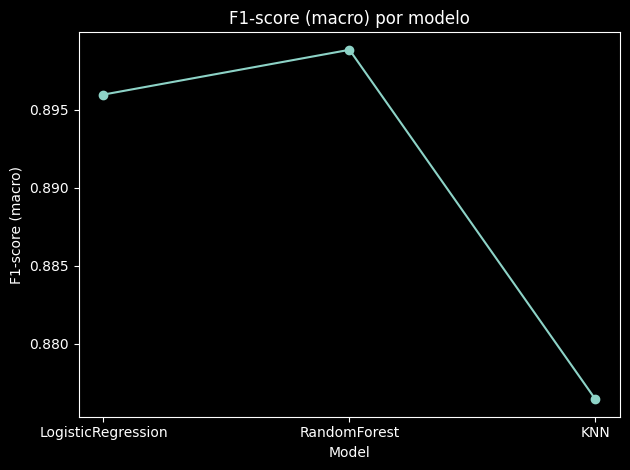


Melhor modelo inicial: RandomForest com F1-score de 0.8988

Iniciando GridSearchCV para o modelo: RandomForest...

Melhores parâmetros encontrados: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Relatório de classificação para o modelo otimizado:
              precision    recall  f1-score   support

         ATT       0.88      0.75      0.81      1930
         DEF       0.92      0.94      0.93      3382
          GK       1.00      1.00      1.00      1130
         MID       0.83      0.87      0.85      3653

    accuracy                           0.89     10095
   macro avg       0.91      0.89      0.90     10095
weighted avg       0.89      0.89      0.89     10095

F1-score do modelo original: 0.8988
F1-score do modelo otimizado: 0.8988
Modelo final selecionado: RandomForestClassifier


In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
# Avalia e seleciona o melhor modelo inicial com F1 macro.
pontuacoes_modelos = {}
for nome, classificador in modelos.items():
    y_previsto = classificador.predict(X_teste_escalado)
    pontuacao = f1_score(y_teste, y_previsto, average="macro")
    pontuacoes_modelos[nome] = pontuacao
    print(f"F1-score (macro) para {nome}: {pontuacao:.4f}")

# Visualizacao do F1-score por modelo
modelos_ordem = list(pontuacoes_modelos.keys())
f1_scores = [pontuacoes_modelos[m] for m in modelos_ordem]

plt.plot(modelos_ordem, f1_scores, marker='o')
plt.xlabel('Model')
plt.ylabel('F1-score (macro)')
plt.title('F1-score (macro) por modelo')
plt.tight_layout()
plt.show()

# Escolhe o modelo de maior F1 macro como candidato à afinação.
nome_melhor_modelo = max(pontuacoes_modelos, key=pontuacoes_modelos.get)
print(
    f"\nMelhor modelo inicial: {nome_melhor_modelo} com F1-score de {pontuacoes_modelos[nome_melhor_modelo]:.4f}"
)
# Define grelhas específicas para cada algoritmo antes de correr o GridSearch.
grelhas_parametros = {
    "LogisticRegression": {
        "C": [0.1, 1.0, 10.0],
        "solver": ["lbfgs", "saga"],
    },
    "RandomForest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5],
    },
    "KNN": {
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"],
    }
}
# Otimiza o melhor modelo com GridSearchCV usando validação cruzada.
modelo_base_melhor = modelos[nome_melhor_modelo]
grelha_a_usar = grelhas_parametros[nome_melhor_modelo]
print(f"\nIniciando GridSearchCV para o modelo: {nome_melhor_modelo}...")
grelha = GridSearchCV(
    estimator=modelo_base_melhor,
    param_grid=grelha_a_usar,
    scoring="f1_macro",
    n_jobs=-1,
    cv=5
)
# Ajusta o modelo com validação cruzada para encontrar a melhor combinação de parâmetros.
grelha.fit(X_treino_escalado, y_treino)
# Avalia o modelo ajustado no conjunto de teste e compara com a referência.
print("\nMelhores parâmetros encontrados:", grelha.best_params_)
modelo_otimizado = grelha.best_estimator_
y_previsto_otimizado = modelo_otimizado.predict(X_teste_escalado)
print("\nRelatório de classificação para o modelo otimizado:")
print(classification_report(y_teste, y_previsto_otimizado))
f1_original = f1_score(
    y_teste,
    modelos[nome_melhor_modelo].predict(X_teste_escalado),
    average="macro"
)
f1_otimizado = f1_score(y_teste, y_previsto_otimizado, average="macro")
print(f"F1-score do modelo original: {f1_original:.4f}")
print(f"F1-score do modelo otimizado: {f1_otimizado:.4f}")
if f1_otimizado < f1_original:
    print("O modelo otimizado ficou abaixo do original, vamos manter o modelo base.")
    modelo_final = modelos[nome_melhor_modelo]
else:
    modelo_final = modelo_otimizado
print(f"Modelo final selecionado: {modelo_final.__class__.__name__}")



## Conclusão
Este notebook mostrou um fluxo completo de classificação de posições no EA FC, desde a preparação e normalização dos dados até à comparação de modelos. A avaliação com métricas por classe permitiu escolher o modelo mais consistente e a otimização via GridSearchCV refinou os hiperparâmetros. Estes passos oferecem uma base sólida para prever o grupo de posição de novos jogadores; futuros ajustes podem incluir engenharia de atributos, balanceamento de classes ou outros algoritmos.
